# Importing packages and libraries

In [154]:
import json
import torch
import matplotlib.pyplot as plt
from conex import Neocortex, prioritize_behaviors, SimpleDendriteStructure, SimpleDendriteComputation, SpikeTrace, \
    NeuronAxon, SynapseInit, WeightInitializer, SimpleDendriticInput, SimpleSTDP, Fire, WeightClip, LIF, \
    WeightNormalization, KWTA
from pymonntorch import NeuronGroup, NeuronDimension, SynapseGroup, EventRecorder, Recorder


from models.activity import ActivityRecorder
from models.dendrites import LateralDendriticInput2D, LateralInhibitionDendriticInput
from models.encoders import FeedDataset, CustomPoisson, Poisson
from models.learnings import PairedSTDPLocalVar, PairedRSTDPLocalVar
from models.trace import ClearSpikeTrace
from simulate import Simulation
from utils.dataset import load_data, add_overlap
from utils.formatter import pretty_format_dict

## Load dataset

In [3]:
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=50, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

# Simple input-output layers without any mechanisms

In [4]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                    w_max=1,
                                    w_min=0,
                                    a_minus=1,
                                    a_plus=1,
                                    positive_bound='soft_bound',
                                    negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


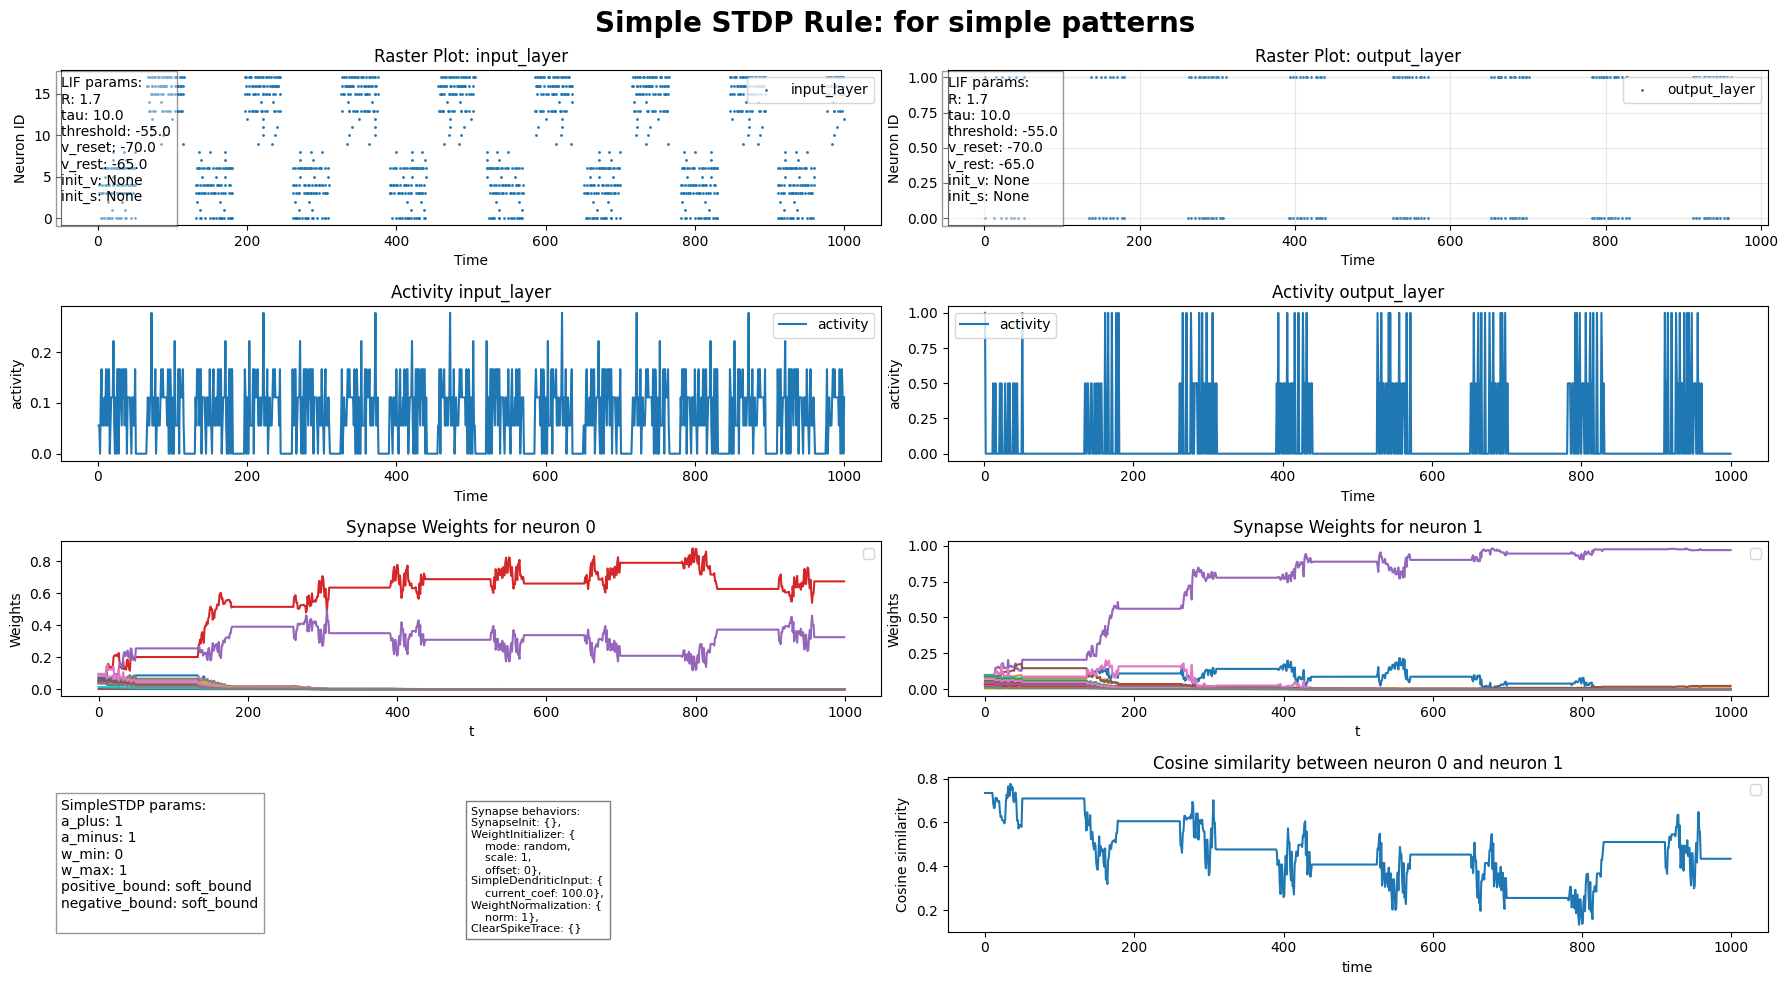

In [5]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3, recorder_behavior_class=Recorder)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4,recorder_behavior_class=Recorder)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5,recorder_behavior_class=Recorder, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)

####### Add extra info #########
ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, learning_behavior_class=SimpleSTDP)
# syn_inp_out.add_synapses_params_info(ax7, synapse_behavior_class=WeightInitializer, text_x=0.22, text_y=0.49)
params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "Synapse behaviors:\n"+pretty_format_dict(params_info)
ax7.text(x=0.5, y=0.0, s=params_info, transform=ax7.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=8)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: for simple patterns", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part1-simple-stdp.pdf")
plt.show()

### Multiple runtime for simple STDP will have different results

In [6]:
sim1 = Simulation(net=Neocortex(dt=1))
input_layer = sim1.add_neuron_group(
    tag="input_layer",
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim1.add_neuron_group(
    tag='output_layer',
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim1.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                    w_max=1,
                                    w_min=0,
                                    a_minus=1,
                                    a_plus=1,
                                    positive_bound='soft_bound',
                                    negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["weights"], tag="syn_inp_out_rec"))

sim1.initialize()
sim1.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  

In [7]:
sim2 = Simulation(net=Neocortex(dt=1))
input_layer = sim2.add_neuron_group(
    tag="input_layer",
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim2.add_neuron_group(
    tag='output_layer',
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim2.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                    w_max=1,
                                    w_min=0,
                                    a_minus=1,
                                    a_plus=1,
                                    positive_bound='soft_bound',
                                    negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["weights"], tag="syn_inp_out_rec"))

sim2.initialize()
sim2.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  

In [8]:
sim3 = Simulation(net=Neocortex(dt=1))
input_layer = sim3.add_neuron_group(
    tag="input_layer",
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim3.add_neuron_group(
    tag='output_layer',
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim3.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                    w_max=1,
                                    w_min=0,
                                    a_minus=1,
                                    a_plus=1,
                                    positive_bound='soft_bound',
                                    negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["weights"], tag="syn_inp_out_rec"))

sim3.initialize()
sim3.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  

/tmp/ipykernel_91695/1724561858.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


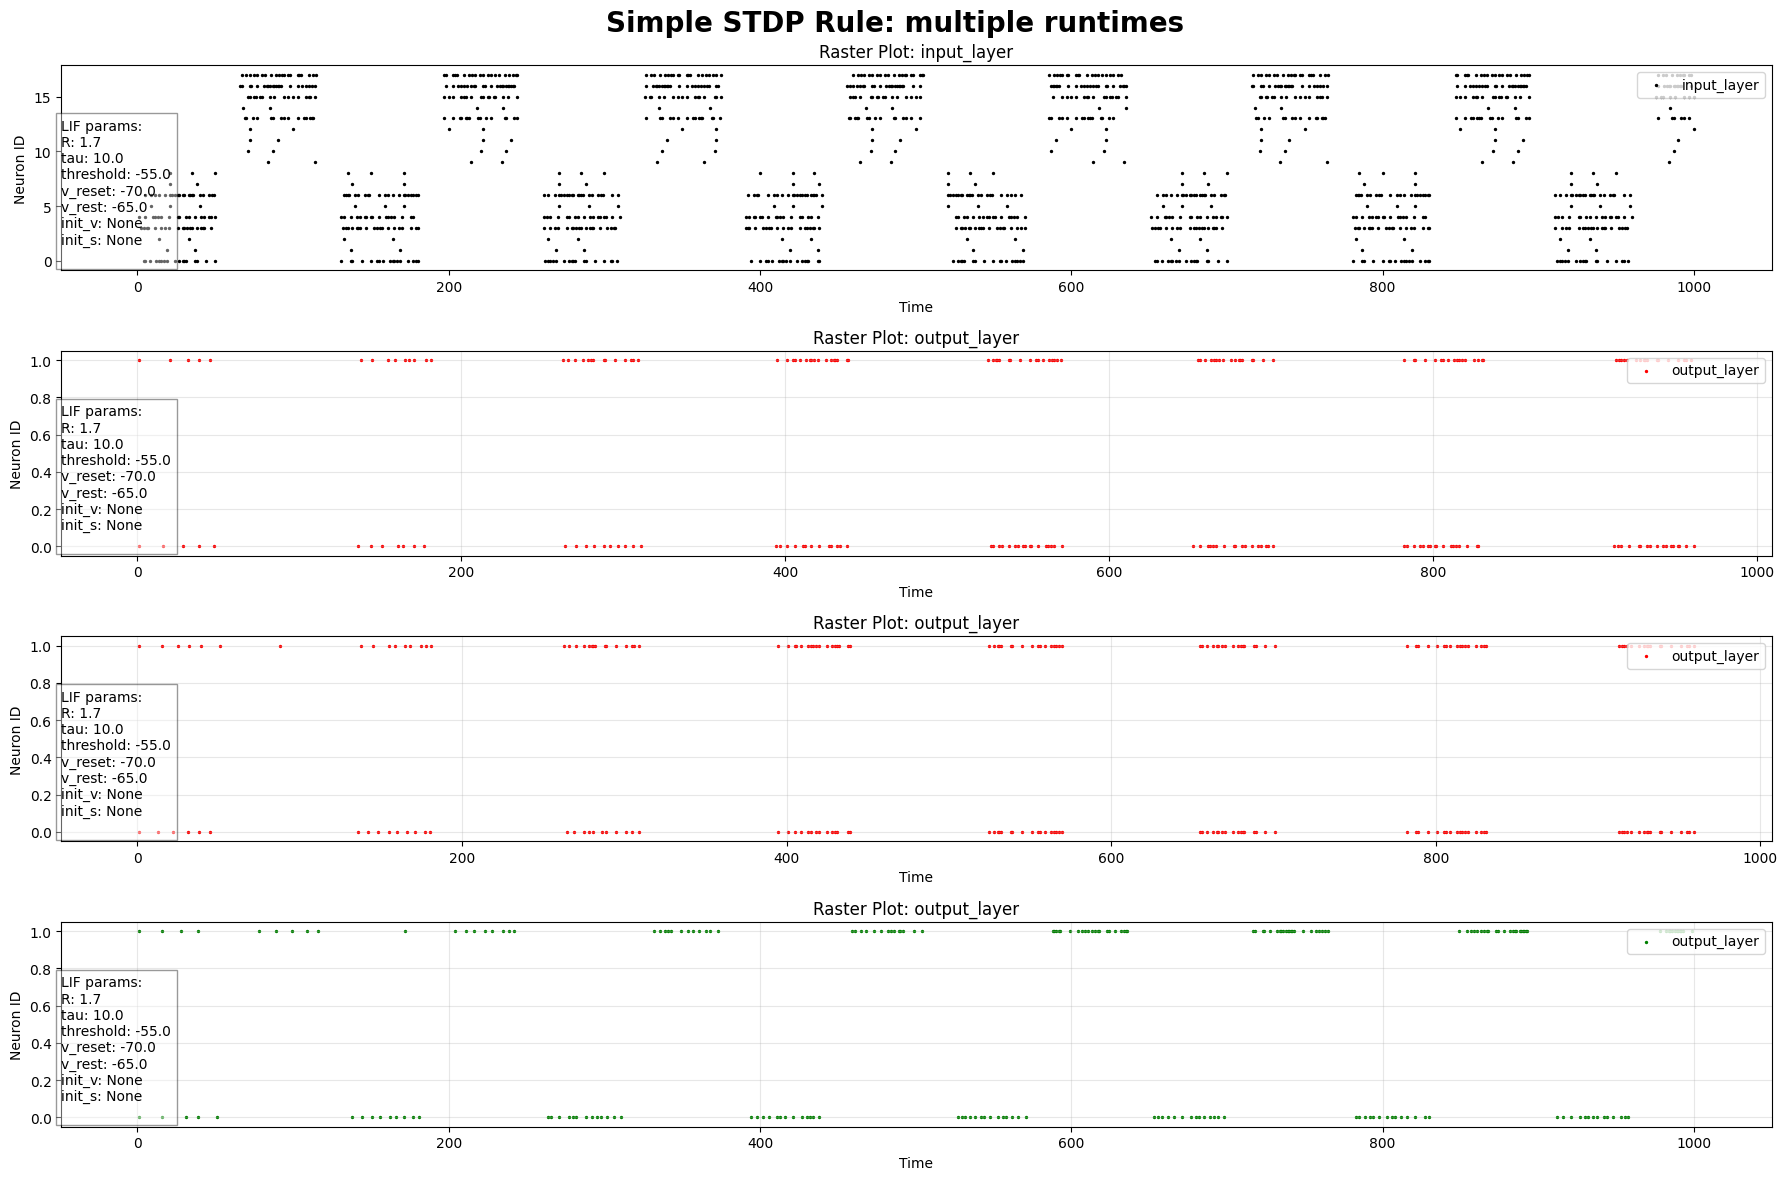

In [11]:
fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(4, 1, 1)
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=2, color='black')
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 1, 2, sharex=ax1)
ax2.grid(True, alpha=0.3)
sim1.net.NeuronGroups[1].add_raster_plot(ax2, EventRecorder, s=2, color='red')
sim1.net.NeuronGroups[1].add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 1, 3)
ax3.grid(True, alpha=0.3)
sim2.net.NeuronGroups[1].add_raster_plot(ax3, EventRecorder, s=2, color='red')
sim2.net.NeuronGroups[1].add_neuron_model_params_info(ax3, model_behavior_class=LIF)

ax4 = fig.add_subplot(4, 1, 4)
ax4.grid(True, alpha=0.3)
sim3.net.NeuronGroups[1].add_raster_plot(ax4, EventRecorder, s=2, color='green')
sim3.net.NeuronGroups[1].add_neuron_model_params_info(ax4, model_behavior_class=LIF)

fig.suptitle("Simple STDP Rule: multiple runtimes", fontsize=20, fontweight='bold')
fig.tight_layout()
# fig.savefig("report/plots/part1-simple-stdp-multiple-runtime.pdf")
fig.show()

# Add Lateral Inhibition

In [27]:
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=50, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [48]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=10.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=1000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(40)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False,  True],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


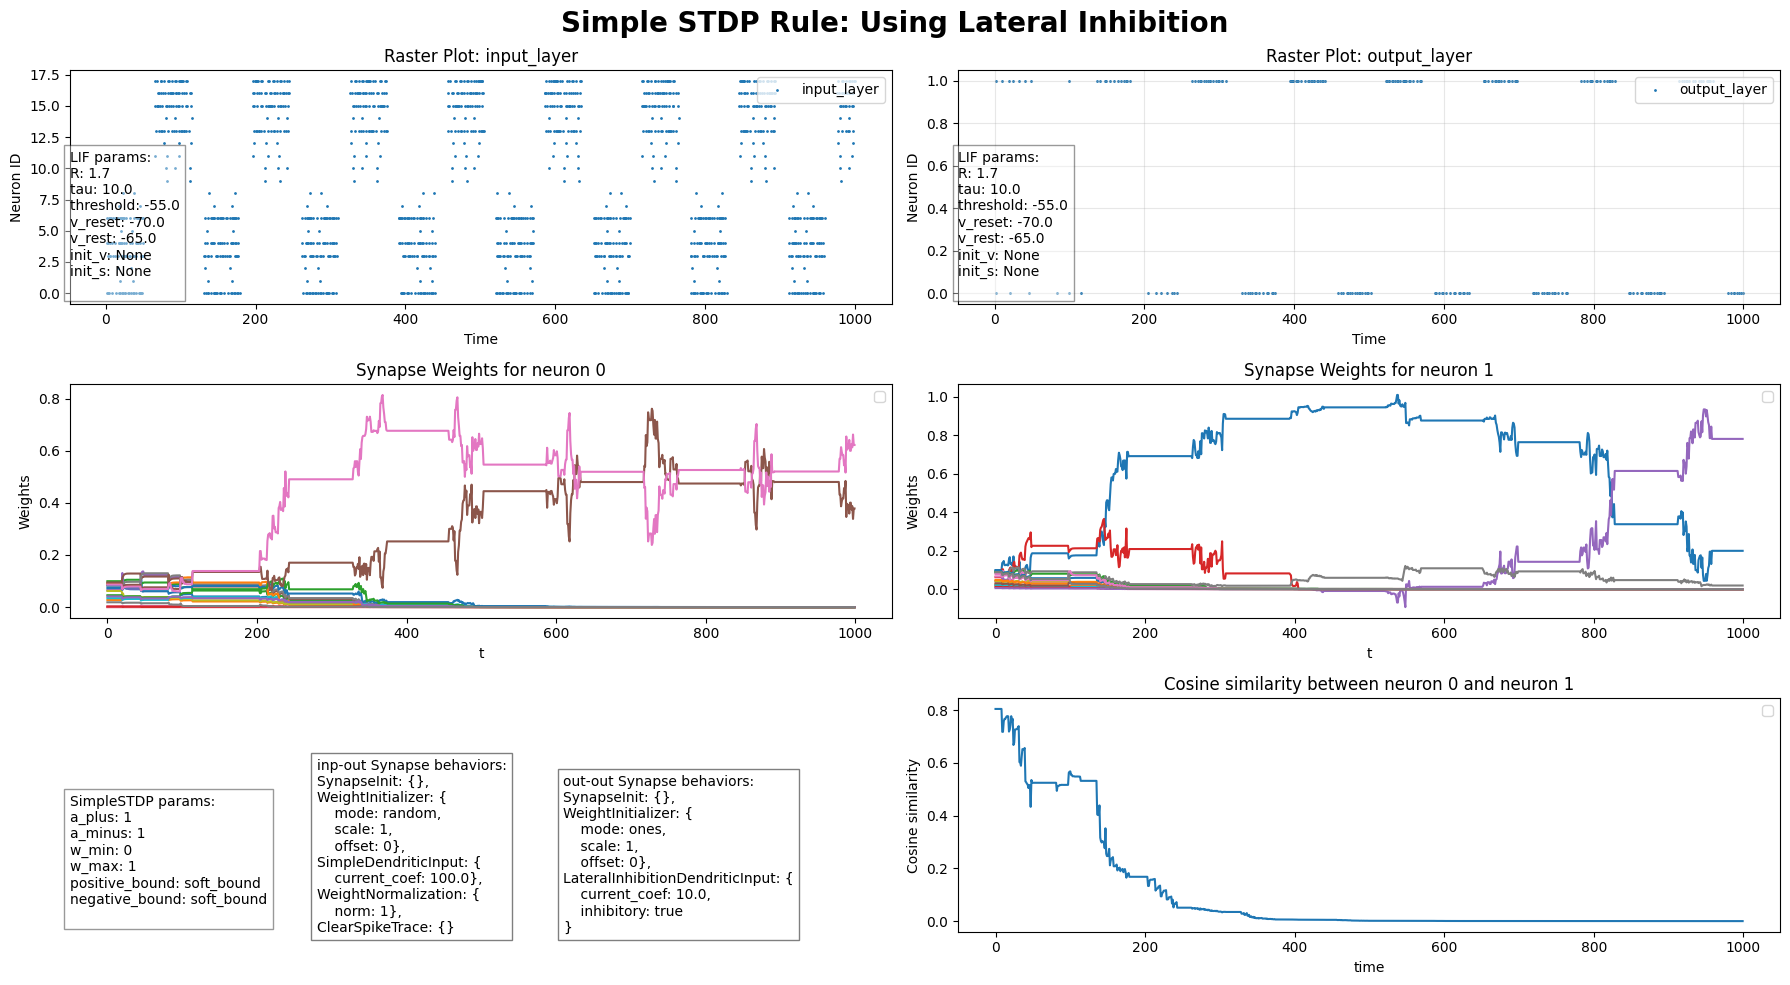

In [49]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 2, 3)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)



ax6 = fig.add_subplot(3, 2, 6)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using Lateral Inhibition", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition.pdf")
plt.show()

### Using larger data

In [138]:
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=100, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [139]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


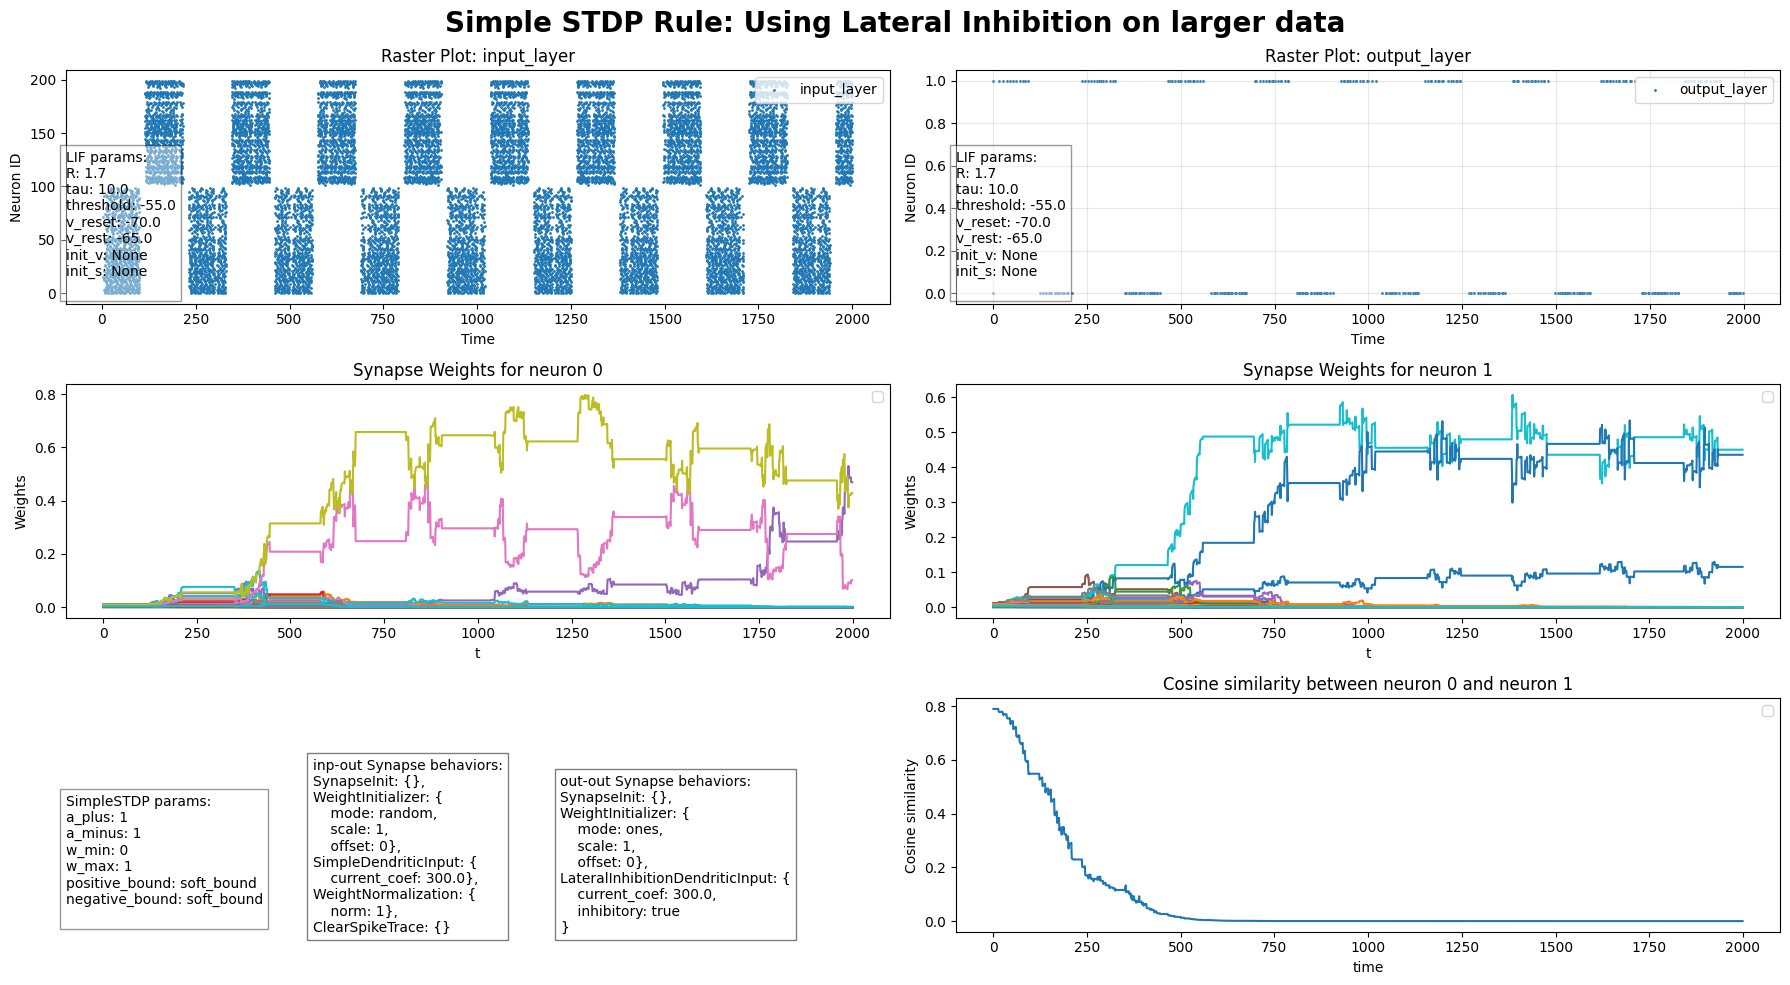

In [140]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 2, 3)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)



ax6 = fig.add_subplot(3, 2, 6)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using Lateral Inhibition on larger data", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition-large-data.pdf")
plt.show()

## Experiment with different overlaps

In [142]:
dataset_low = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_low = add_overlap(dataset_low, overlap_ratio=30, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=100, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_low = torch.stack([encoder(image) for image in dataset_low])

sim1 = Simulation(net=Neocortex(dt=1))
input_layer = sim1.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_low[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_low,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim1.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim1.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim1.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim1.initialize()
sim1.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(172)|2 groups, Synapses: tensor(344)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](170){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False,  True,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [143]:
dataset_mid = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_mid = add_overlap(dataset_mid, overlap_ratio=60, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=100, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_mid = torch.stack([encoder(image) for image in dataset_mid])

sim2 = Simulation(net=Neocortex(dt=1))
input_layer = sim2.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_mid[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_mid,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim2.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim2.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim2.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim2.initialize()
sim2.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(142)|2 groups, Synapses: tensor(284)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](140){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [144]:
dataset_high = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_high = add_overlap(dataset_high, overlap_ratio=100, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=100, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_high = torch.stack([encoder(image) for image in dataset_high])

sim3 = Simulation(net=Neocortex(dt=1))
input_layer = sim3.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_high[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_high,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim3.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim3.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=500.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim3.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=400.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim3.initialize()
sim3.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(102)|2 groups, Synapses: tensor(204)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](100){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


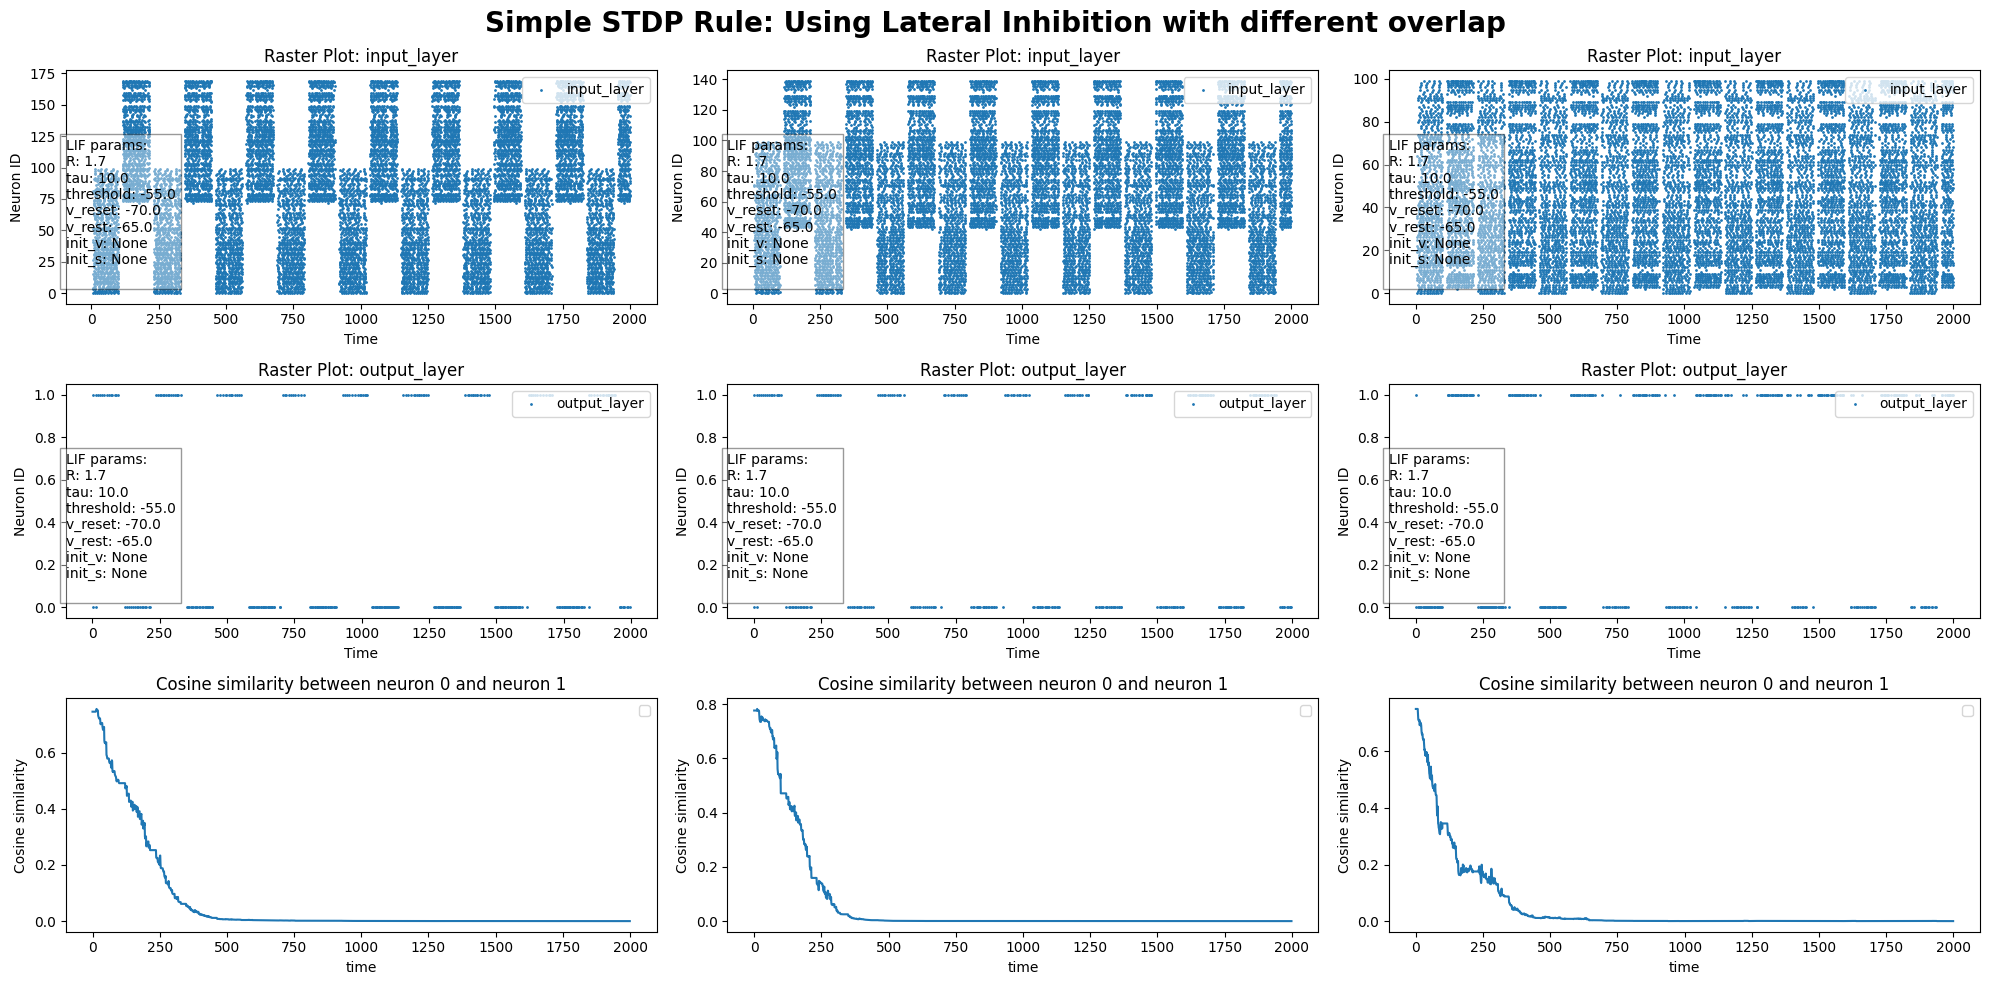

In [147]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(3, 3, 1)
sim1.net.NeuronGroups[0].add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
sim1.net.NeuronGroups[0].add_neuron_model_params_info(ax1,text_y=0.1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 3, 2)
sim2.net.NeuronGroups[0].add_raster_plot(ax2, event_recorder_class=EventRecorder ,s=1)
sim2.net.NeuronGroups[0].add_neuron_model_params_info(ax2,text_y=0.1, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 3, 3)
sim3.net.NeuronGroups[0].add_raster_plot(ax3, event_recorder_class=EventRecorder ,s=1)
sim3.net.NeuronGroups[0].add_neuron_model_params_info(ax3,text_y=0.1, model_behavior_class=LIF)


ax4 = fig.add_subplot(3, 3, 4)
ax4.grid(True, alpha=0.3)
sim1.net.NeuronGroups[1].add_raster_plot(ax4, event_recorder_class=EventRecorder ,s=1)
sim1.net.NeuronGroups[1].add_neuron_model_params_info(ax4,text_y=0.1, model_behavior_class=LIF)

ax5 = fig.add_subplot(3, 3, 5)
ax5.grid(True, alpha=0.3)
sim2.net.NeuronGroups[1].add_raster_plot(ax5, event_recorder_class=EventRecorder ,s=1)
sim2.net.NeuronGroups[1].add_neuron_model_params_info(ax5,text_y=0.1, model_behavior_class=LIF)

ax6 = fig.add_subplot(3, 3, 6)
ax6.grid(True, alpha=0.3)
sim3.net.NeuronGroups[1].add_raster_plot(ax6, event_recorder_class=EventRecorder ,s=1)
sim3.net.NeuronGroups[1].add_neuron_model_params_info(ax6,text_y=0.1, model_behavior_class=LIF)


ax7 = fig.add_subplot(3, 3, 7)
sim1.net.SynapseGroups[0].add_cosine_similarity_plot(ax7,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax8 = fig.add_subplot(3, 3, 8)
sim2.net.SynapseGroups[0].add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax9 = fig.add_subplot(3, 3, 9)
sim3.net.SynapseGroups[0].add_cosine_similarity_plot(ax9,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using Lateral Inhibition with different overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition-different-overlap.pdf")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


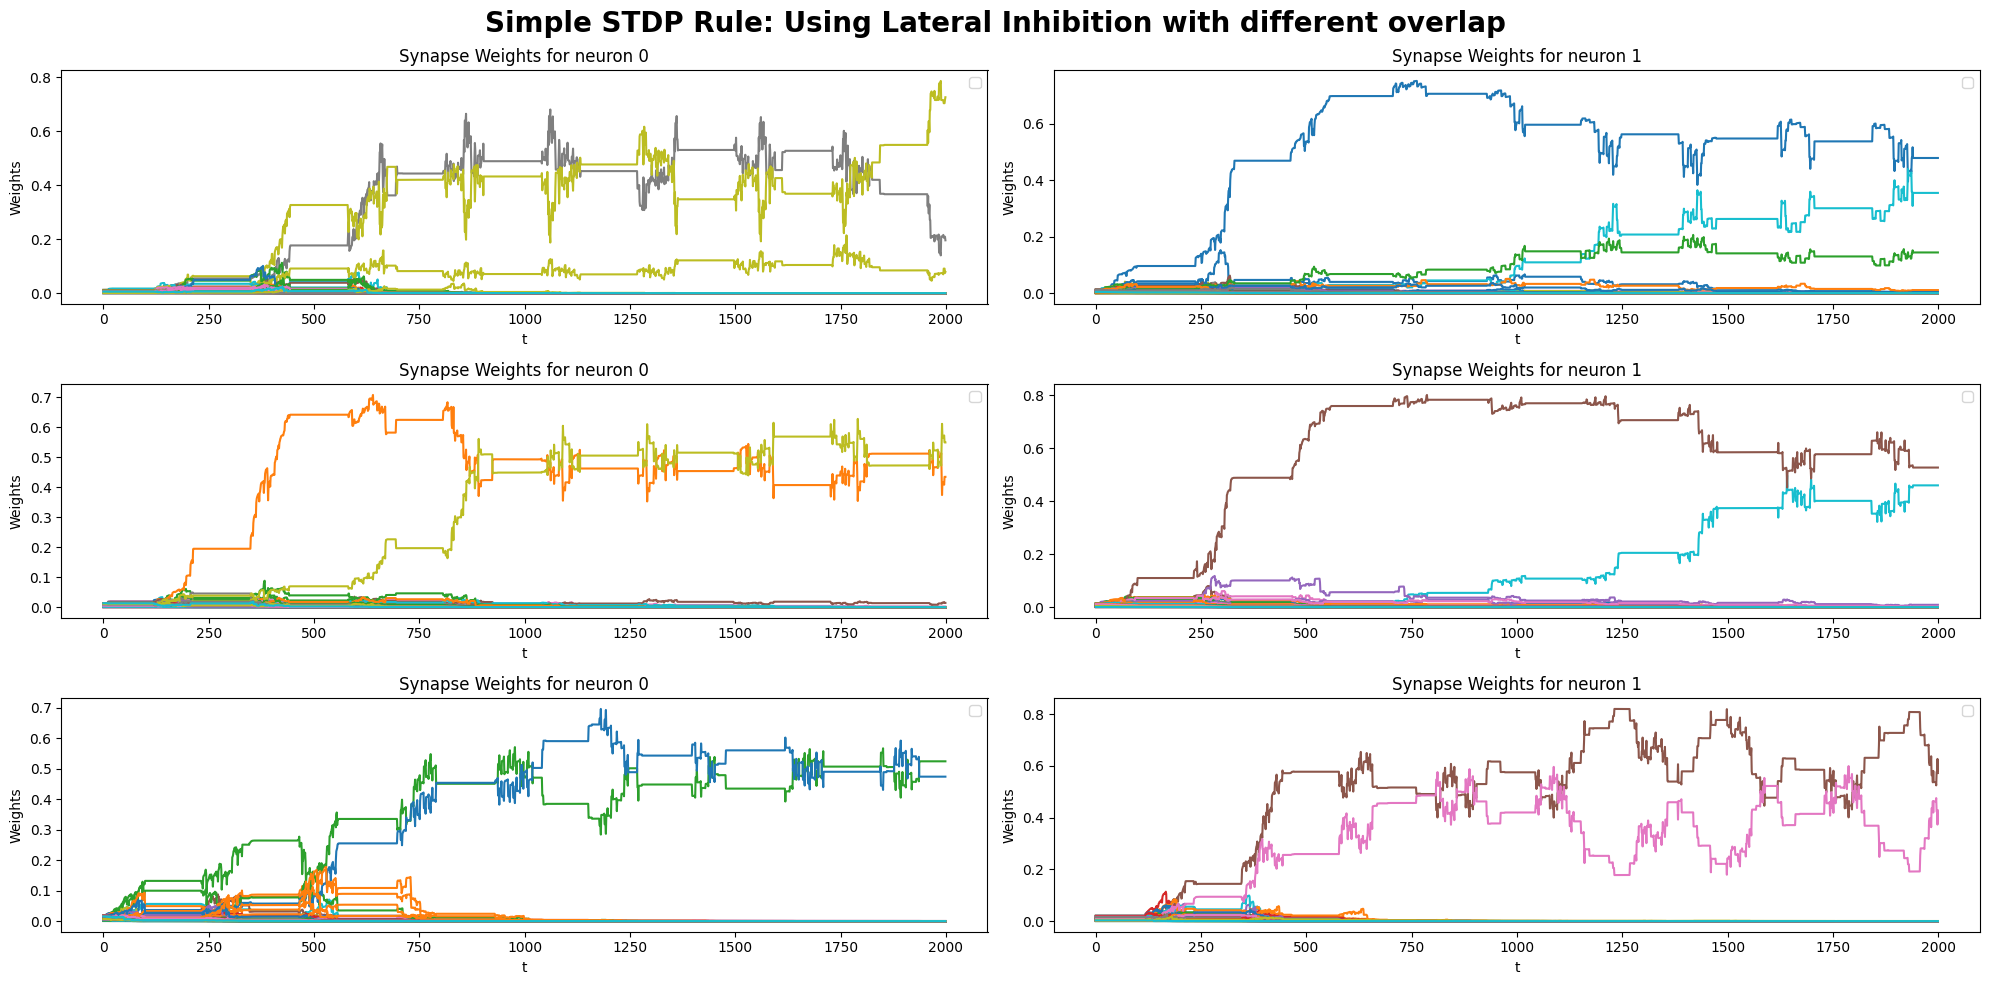

In [151]:
fig = plt.figure(figsize=(20, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)
sim1.net.SynapseGroups[0].add_weights_plot(ax1, recorder_behavior_class=Recorder, neuron_id=0)

ax2 = fig.add_subplot(3, 2, 2)
sim1.net.SynapseGroups[0].add_weights_plot(ax2, recorder_behavior_class=Recorder, neuron_id=1)

ax3 = fig.add_subplot(3, 2, 3)
sim2.net.SynapseGroups[0].add_weights_plot(ax3, recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
sim2.net.SynapseGroups[0].add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
sim3.net.SynapseGroups[0].add_weights_plot(ax5, recorder_behavior_class=Recorder, neuron_id=0)

ax6 = fig.add_subplot(3, 2, 6)
sim3.net.SynapseGroups[0].add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)
fig.suptitle("Simple STDP Rule: Using Lateral Inhibition with different overlap: weights", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-lateral-inhibition-different-overlap-weights.pdf")
plt.show()

# Add K-Winners Take All

In [175]:
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=50, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [176]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)

        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


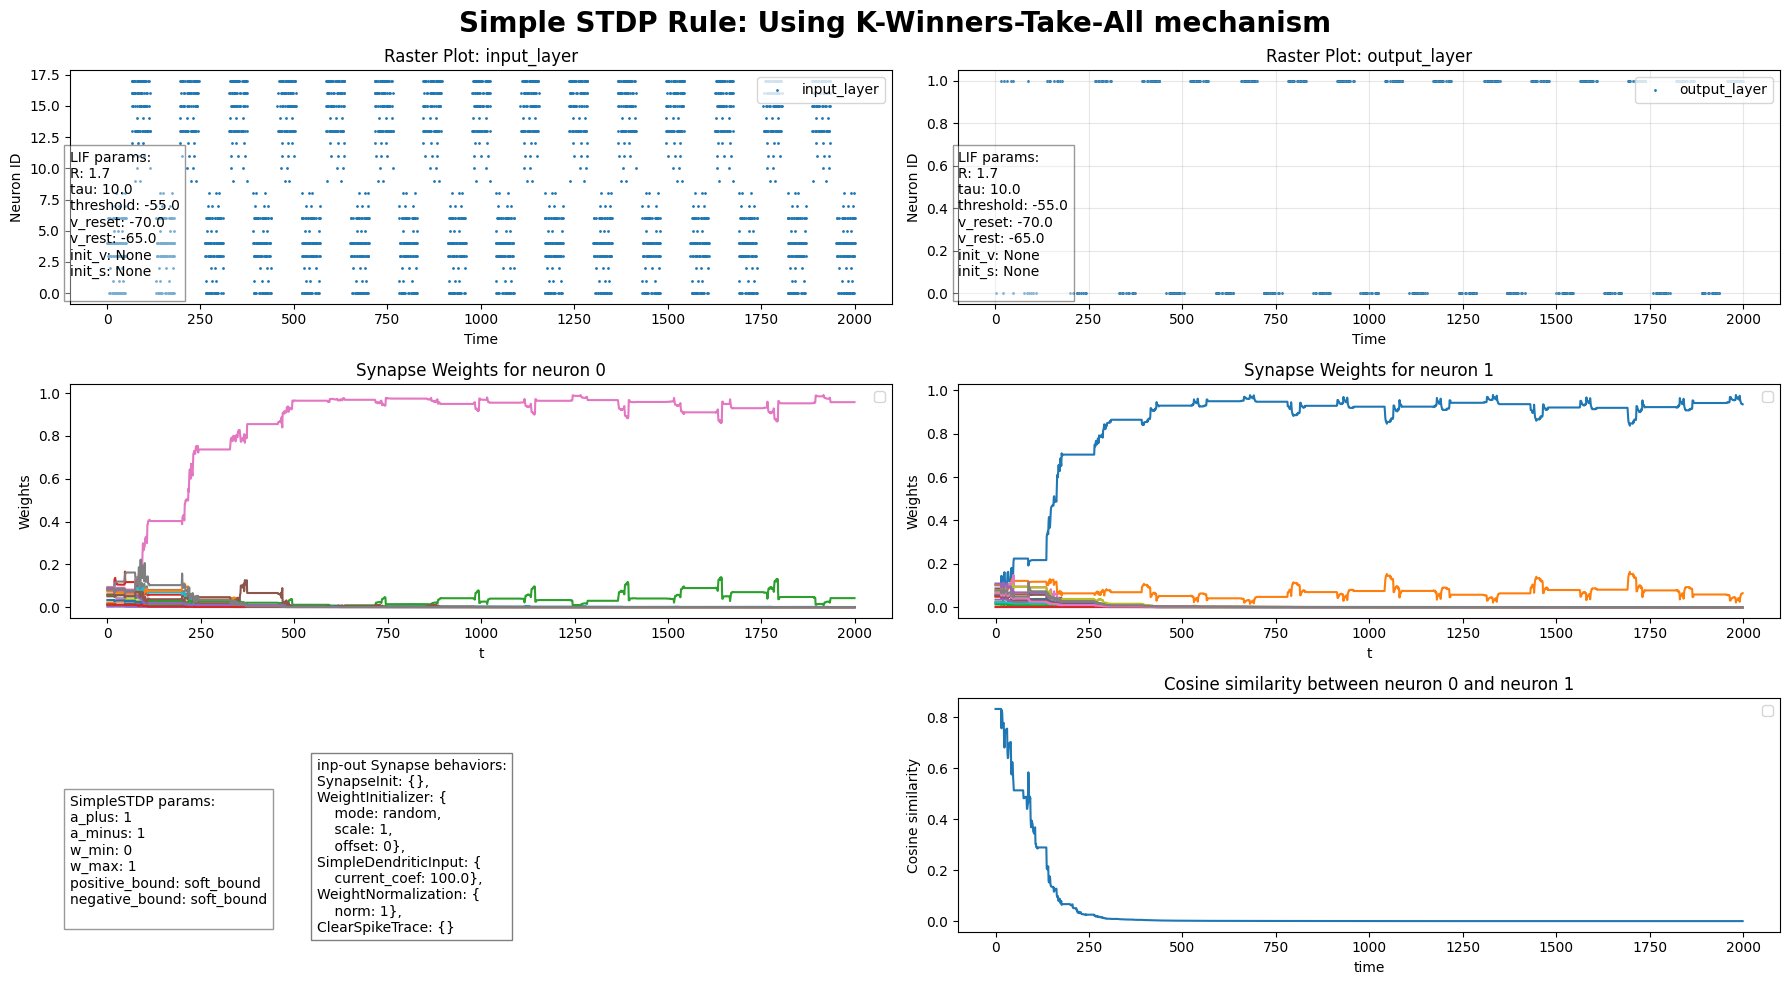

In [184]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 2, 3)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)



ax6 = fig.add_subplot(3, 2, 6)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using K-Winners-Take-All mechanism", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-kwta.pdf")
plt.show()

## with waterloo dataset:

In [194]:
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=75, ratio=0.25)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [195]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)

        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(400)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False,  True],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


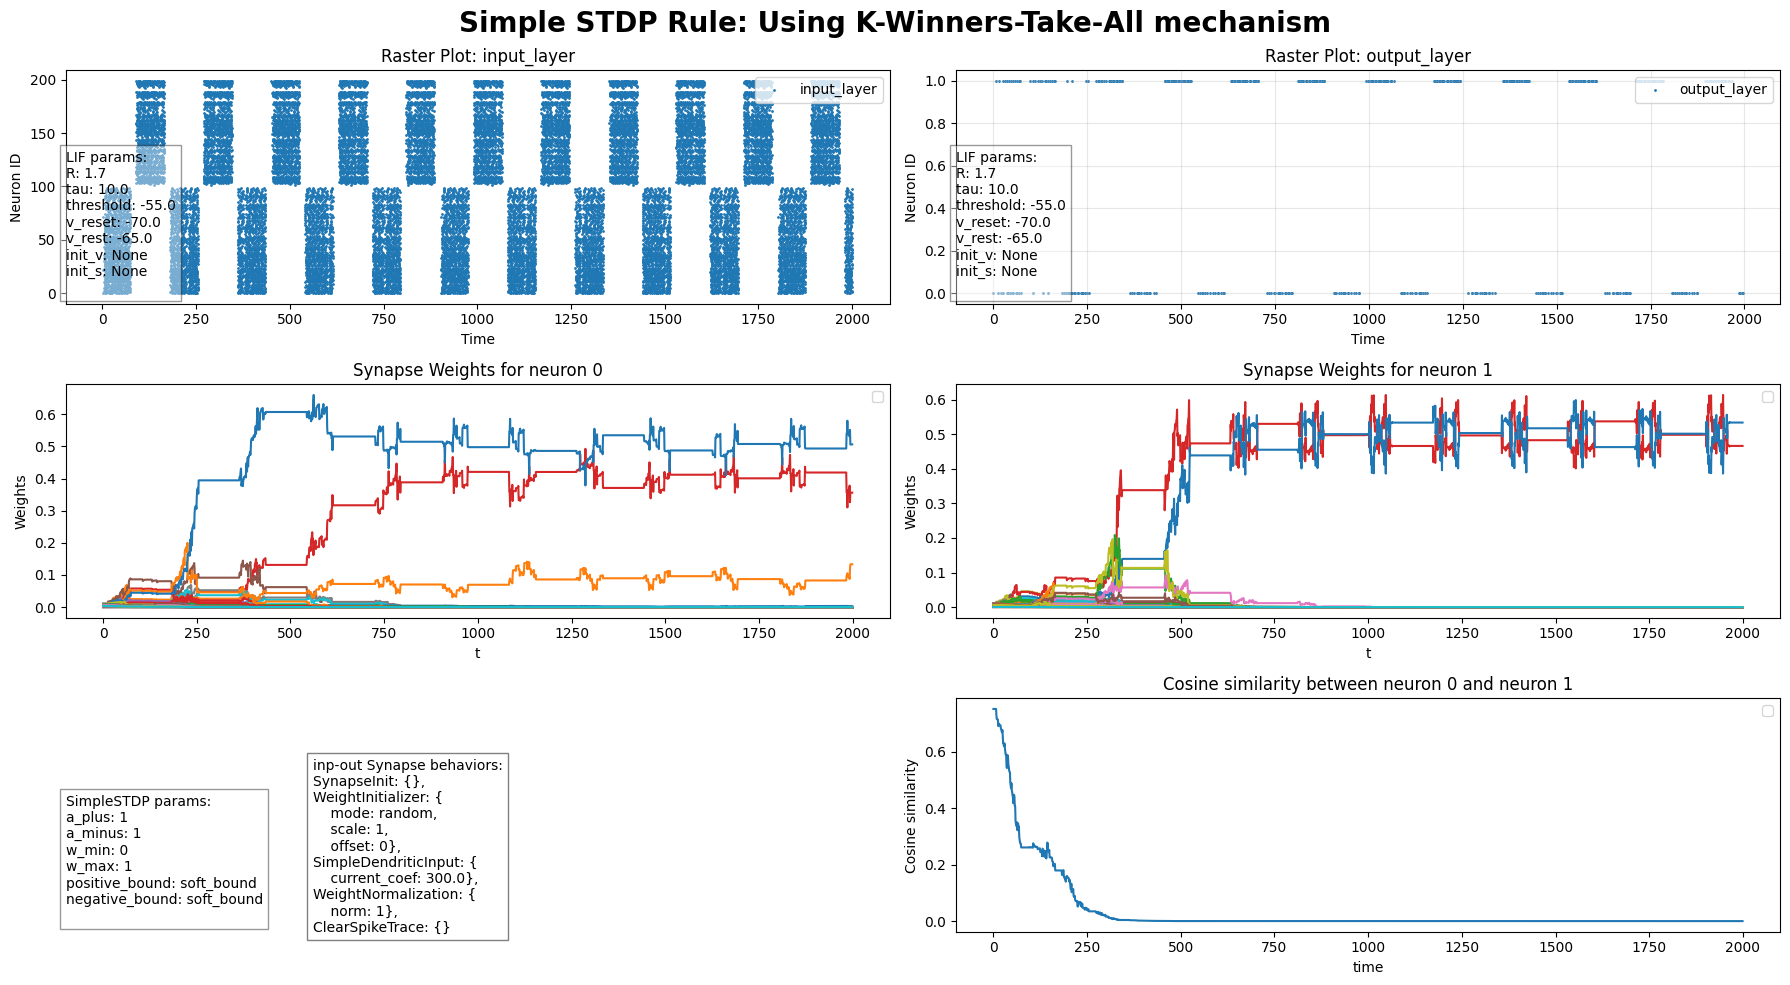

In [197]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 2, 3)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)



ax6 = fig.add_subplot(3, 2, 6)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using K-Winners-Take-All mechanism", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-kwta-larger-data.pdf")
plt.show()

## KWTA plus Lateral inhibition

In [198]:
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=50, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [207]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=10.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(40)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


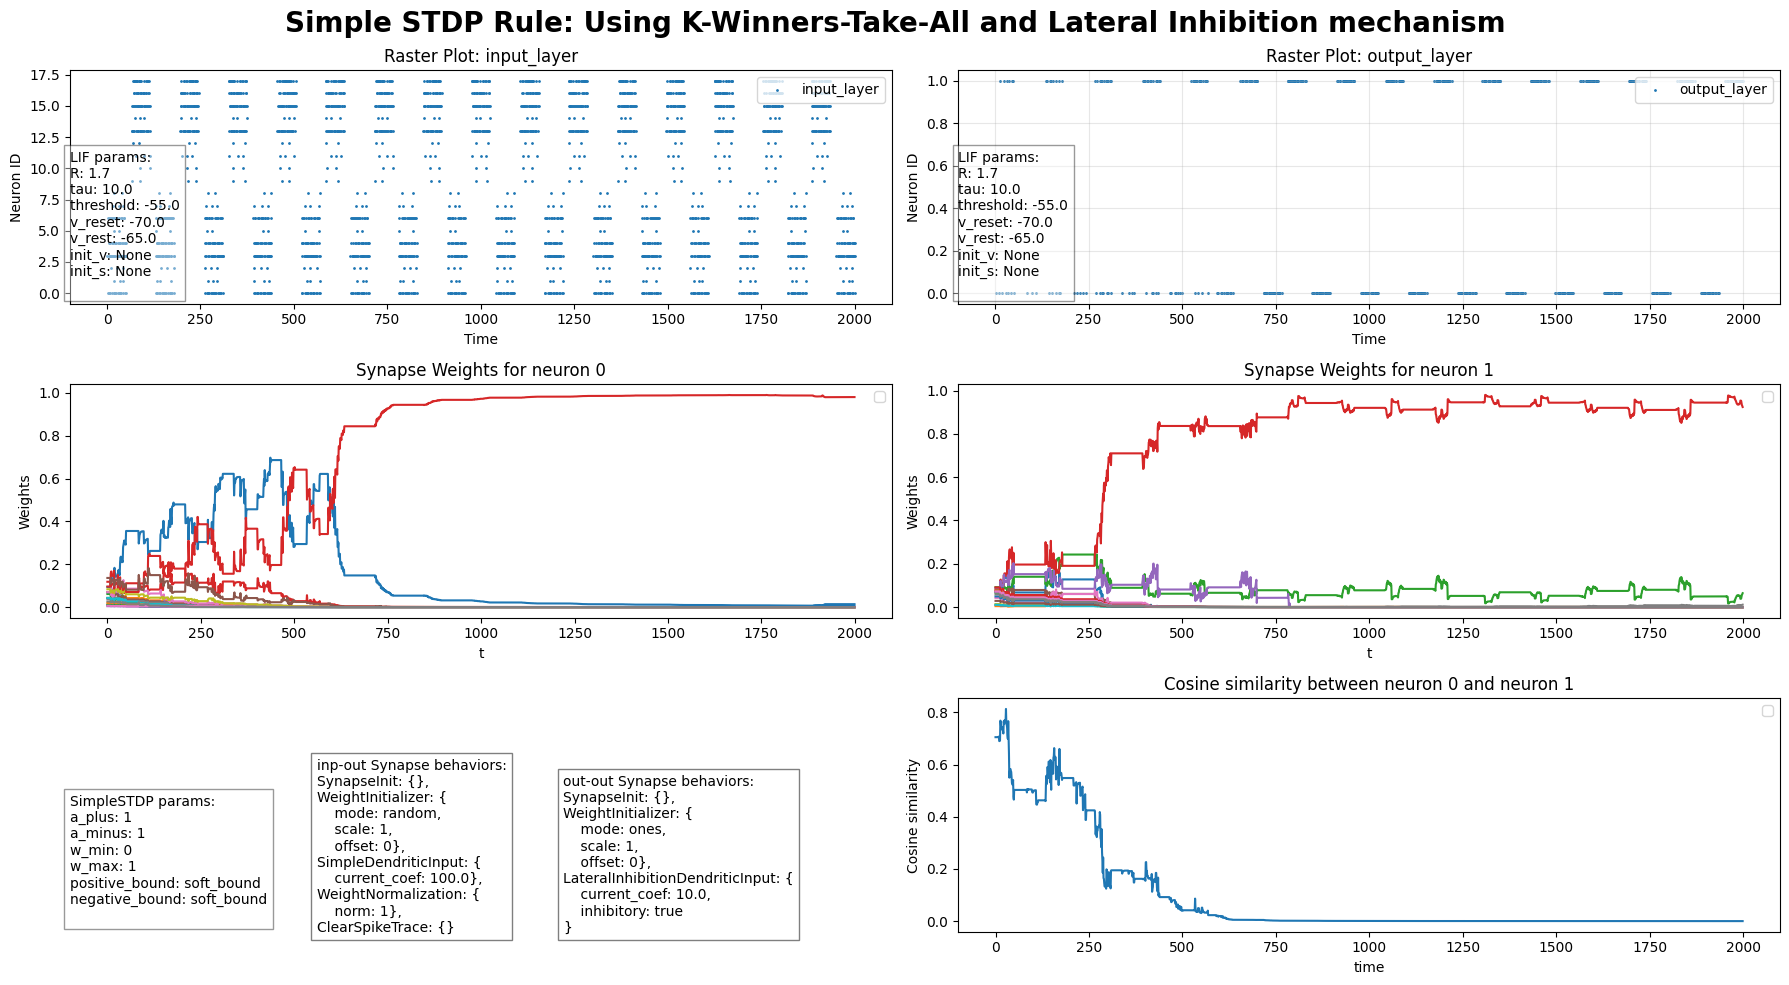

In [209]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 2, 3)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


ax6 = fig.add_subplot(3, 2, 6)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using K-Winners-Take-All and Lateral Inhibition mechanism", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-kwta-lateral-inhibtion.pdf")
plt.show()

### Experiment with waterloo dataset(larger data)

In [243]:
dataset = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset = add_overlap(dataset, overlap_ratio=0.0, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=75, ratio=0.15)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [251]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=400.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(202)|2 groups, Synapses: tensor(404)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](200){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


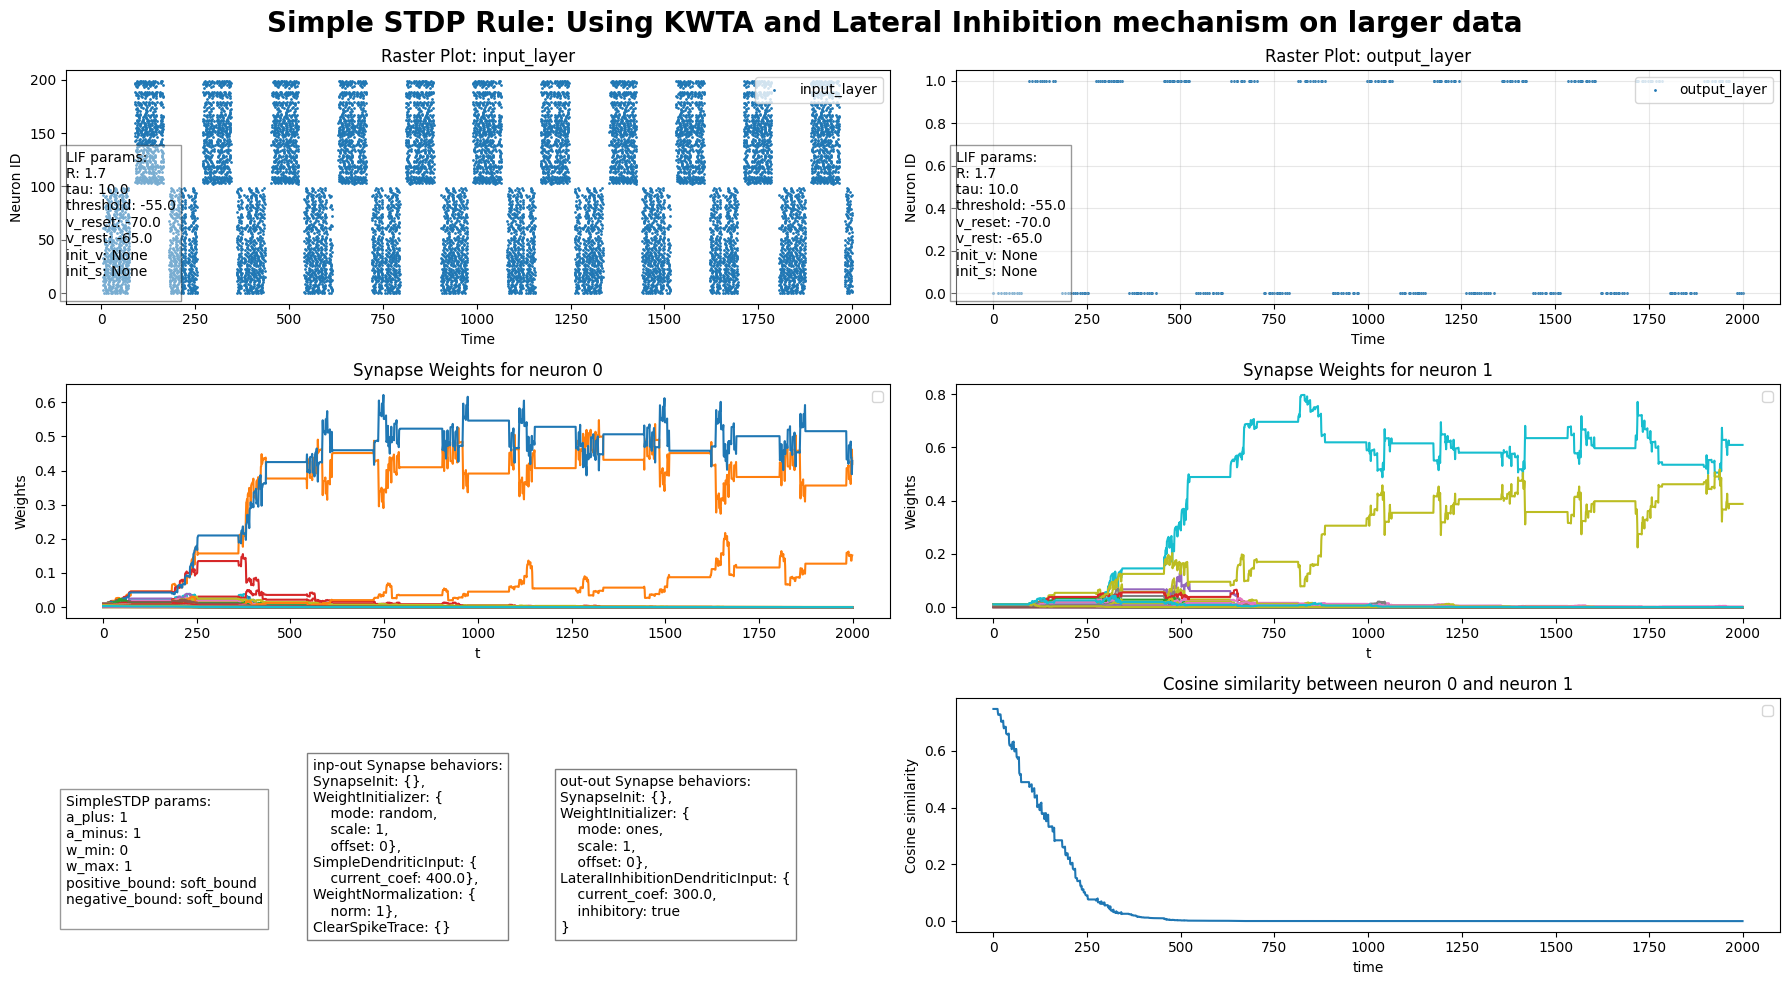

In [253]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 2, 3)
syn_inp_out.add_weights_plot(ax3,recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
syn_inp_out.add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
ax5.axis("off")
# syn_out_out.add_current_plot(ax5, recorder_behavior_class=Recorder)
syn_inp_out.add_learning_params_info(ax5, learning_behavior_class=SimpleSTDP)

params_info = dict()
for key, behavior in syn_inp_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "inp-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.3, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)

params_info = dict()
for key, behavior in syn_out_out.behavior.items():
    if behavior.__class__.__name__ not in ["WeightInitializer", "SimpleSTDP", "Recorder"]:
        params_info[behavior.__class__.__name__]= behavior.init_kwargs
    if behavior.__class__.__name__ == "WeightInitializer":
        params_info[behavior.__class__.__name__] = {key:value for key,value in behavior.init_kwargs.items() if key in ["mode", "scale", "offset"]}
params_info = "out-out Synapse behaviors:\n"+pretty_format_dict(params_info)
ax5.text(x=0.6, y=0.0, s=params_info, transform=ax5.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                fontsize=10)


ax6 = fig.add_subplot(3, 2, 6)
syn_inp_out.add_cosine_similarity_plot(ax6,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: Using KWTA and Lateral Inhibition mechanism on larger data", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-kwta-lateral-inhibtion-larger-data.pdf")
plt.show()

## Different overlap: KWTA

In [304]:
dataset_low = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_low = add_overlap(dataset_low, overlap_ratio=30, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=75, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_low = torch.stack([encoder(image) for image in dataset_low])

sim1 = Simulation(net=Neocortex(dt=1))
input_layer = sim1.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_low[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_low,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim1.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim1.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=200.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim1.initialize()
sim1.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(172)|2 groups, Synapses: tensor(340)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](170){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [305]:
dataset_mid = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_mid = add_overlap(dataset_mid, overlap_ratio=60, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=75, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_mid = torch.stack([encoder(image) for image in dataset_mid])

sim2 = Simulation(net=Neocortex(dt=1))
input_layer = sim2.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_mid[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_mid,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim2.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim2.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=100.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim2.initialize()
sim2.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(142)|2 groups, Synapses: tensor(280)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](140){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [306]:
dataset_high = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_high = add_overlap(dataset_high, overlap_ratio=100, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=75, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_high = torch.stack([encoder(image) for image in dataset_high])

sim3 = Simulation(net=Neocortex(dt=1))
input_layer = sim3.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_high[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_high,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim3.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim3.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=350.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim3.initialize()
sim3.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(102)|2 groups, Synapses: tensor(200)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](100){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False,  True],
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


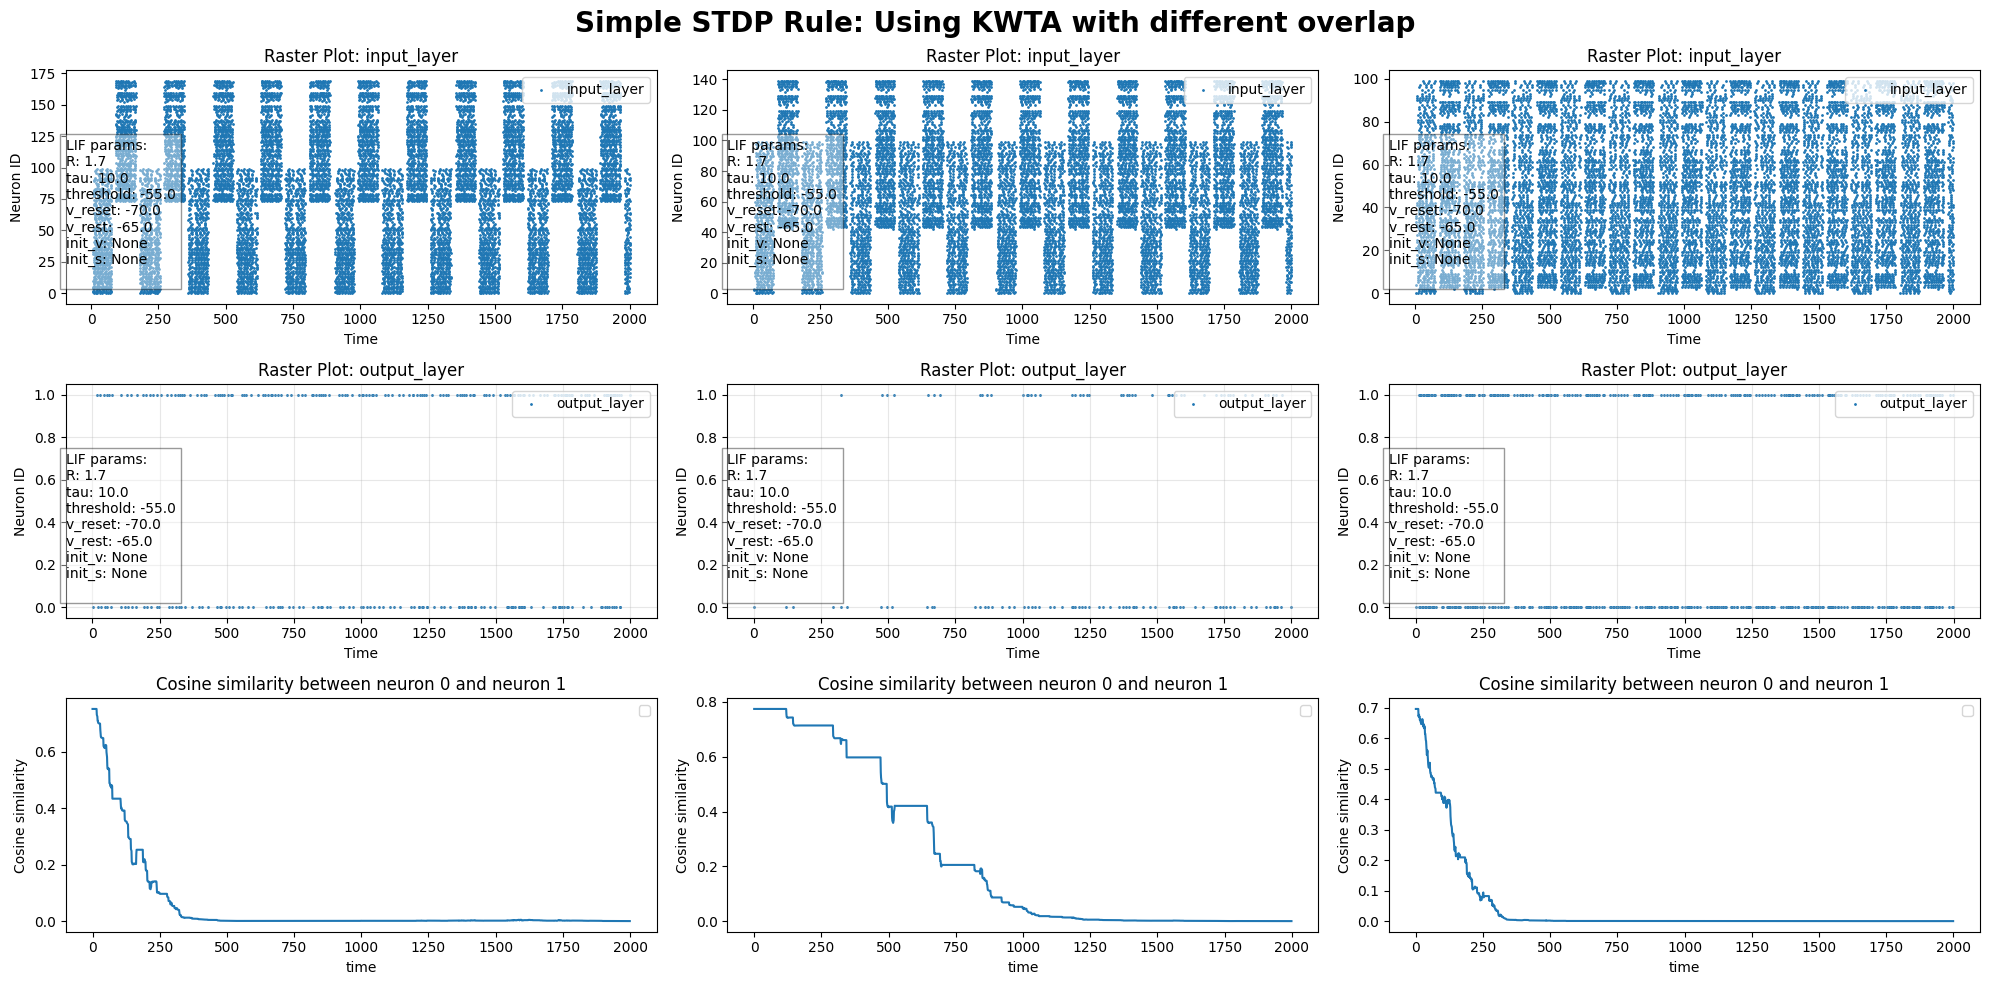

In [307]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(3, 3, 1)
sim1.net.NeuronGroups[0].add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
sim1.net.NeuronGroups[0].add_neuron_model_params_info(ax1,text_y=0.1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 3, 2)
sim2.net.NeuronGroups[0].add_raster_plot(ax2, event_recorder_class=EventRecorder ,s=1)
sim2.net.NeuronGroups[0].add_neuron_model_params_info(ax2,text_y=0.1, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 3, 3)
sim3.net.NeuronGroups[0].add_raster_plot(ax3, event_recorder_class=EventRecorder ,s=1)
sim3.net.NeuronGroups[0].add_neuron_model_params_info(ax3,text_y=0.1, model_behavior_class=LIF)


ax4 = fig.add_subplot(3, 3, 4)
ax4.grid(True, alpha=0.3)
sim1.net.NeuronGroups[1].add_raster_plot(ax4, event_recorder_class=EventRecorder ,s=1)
sim1.net.NeuronGroups[1].add_neuron_model_params_info(ax4,text_y=0.1, model_behavior_class=LIF)

ax5 = fig.add_subplot(3, 3, 5)
ax5.grid(True, alpha=0.3)
sim2.net.NeuronGroups[1].add_raster_plot(ax5, event_recorder_class=EventRecorder ,s=1)
sim2.net.NeuronGroups[1].add_neuron_model_params_info(ax5,text_y=0.1, model_behavior_class=LIF)

ax6 = fig.add_subplot(3, 3, 6)
ax6.grid(True, alpha=0.3)
sim3.net.NeuronGroups[1].add_raster_plot(ax6, event_recorder_class=EventRecorder ,s=1)
sim3.net.NeuronGroups[1].add_neuron_model_params_info(ax6,text_y=0.1, model_behavior_class=LIF)


ax7 = fig.add_subplot(3, 3, 7)
sim1.net.SynapseGroups[0].add_cosine_similarity_plot(ax7,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax8 = fig.add_subplot(3, 3, 8)
sim2.net.SynapseGroups[0].add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax9 = fig.add_subplot(3, 3, 9)
sim3.net.SynapseGroups[0].add_cosine_similarity_plot(ax9,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using KWTA with different overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig("report/plots/part1-simple-stdp-kwta-different-overlap.pdf")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


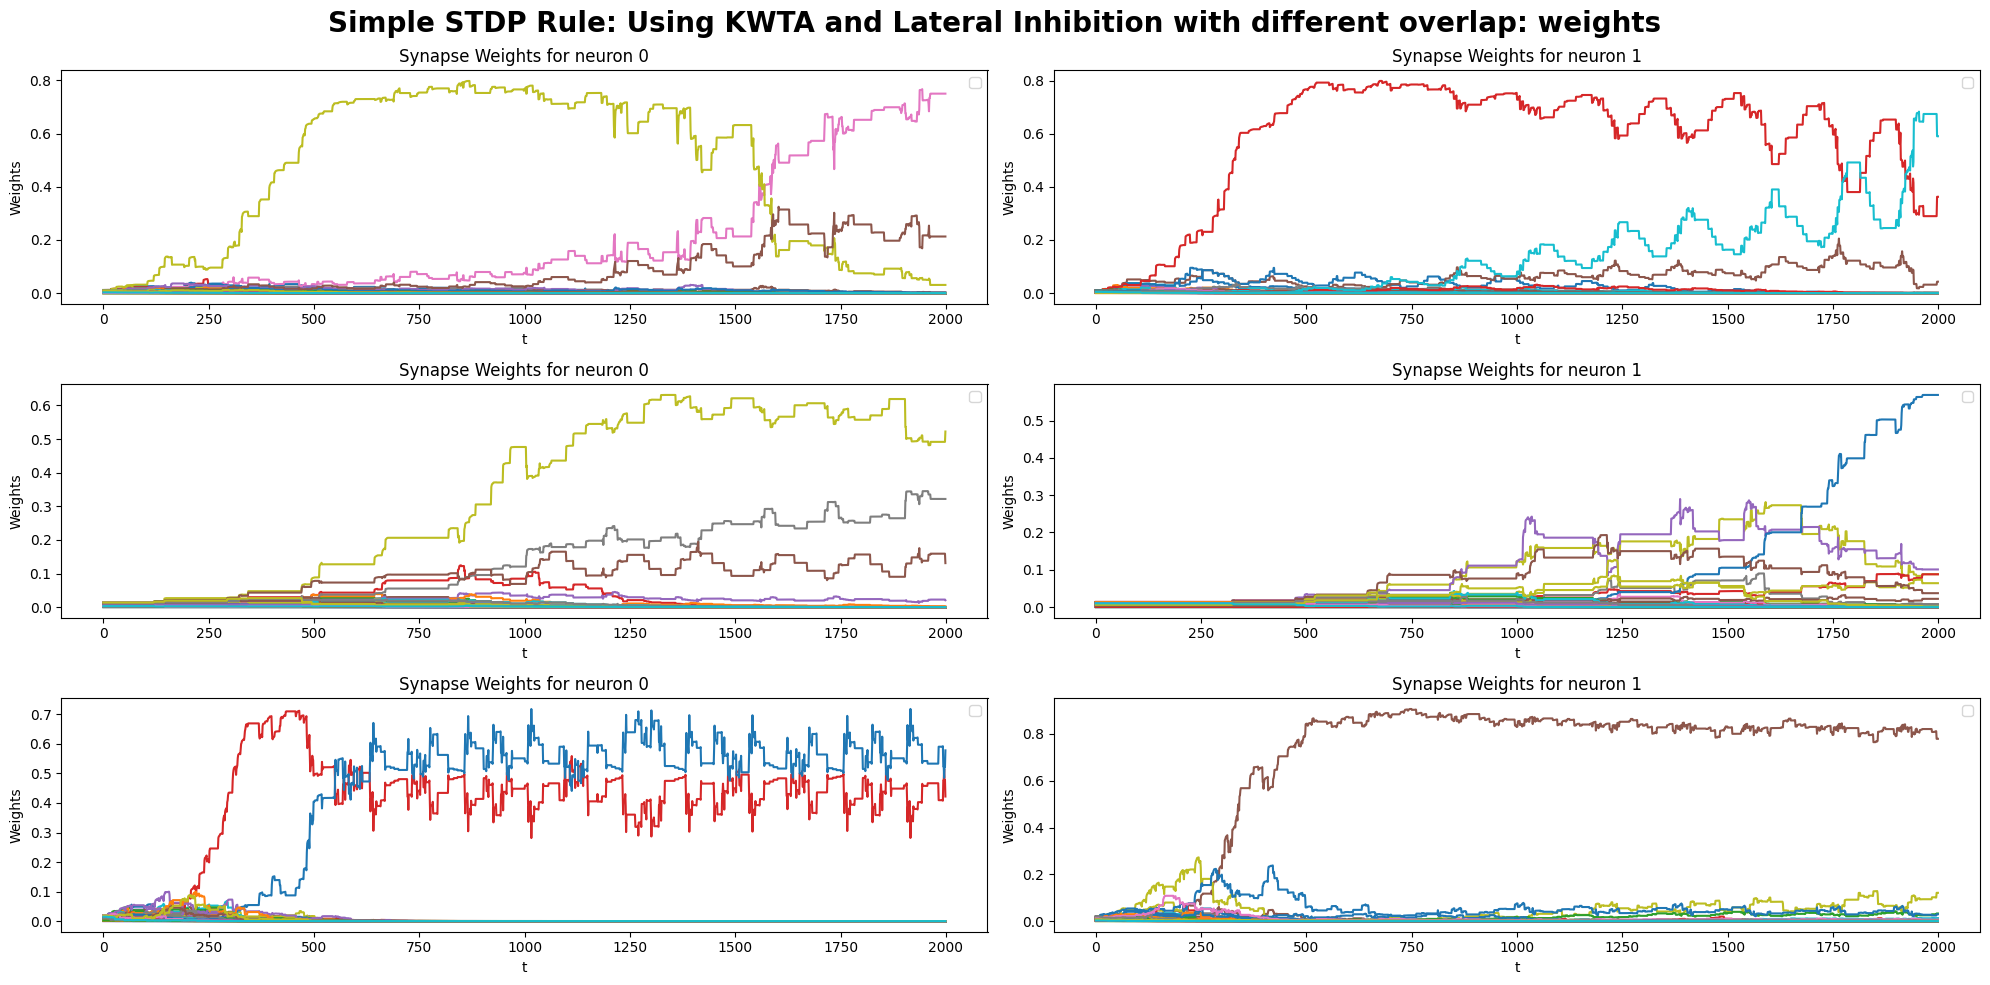

In [309]:
fig = plt.figure(figsize=(20, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(3, 2, 1)
sim1.net.SynapseGroups[0].add_weights_plot(ax1, recorder_behavior_class=Recorder, neuron_id=0)

ax2 = fig.add_subplot(3, 2, 2)
sim1.net.SynapseGroups[0].add_weights_plot(ax2, recorder_behavior_class=Recorder, neuron_id=1)

ax3 = fig.add_subplot(3, 2, 3)
sim2.net.SynapseGroups[0].add_weights_plot(ax3, recorder_behavior_class=Recorder, neuron_id=0)

ax4 = fig.add_subplot(3, 2, 4)
sim2.net.SynapseGroups[0].add_weights_plot(ax4, recorder_behavior_class=Recorder, neuron_id=1)

ax5 = fig.add_subplot(3, 2, 5)
sim3.net.SynapseGroups[0].add_weights_plot(ax5, recorder_behavior_class=Recorder, neuron_id=0)

ax6 = fig.add_subplot(3, 2, 6)
sim3.net.SynapseGroups[0].add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)
fig.suptitle("Simple STDP Rule: Using KWTA with different overlap: weights", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-kwta-different-overlap-weights.pdf")
plt.show()

## Different overlap: KWTA and Lateral Inhibtion

In [310]:
dataset_low = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_low = add_overlap(dataset_low, overlap_ratio=30, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=75, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_low = torch.stack([encoder(image) for image in dataset_low])

sim1 = Simulation(net=Neocortex(dt=1))
input_layer = sim1.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_low[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_low,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim1.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim1.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim1.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=300.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim1.initialize()
sim1.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(172)|2 groups, Synapses: tensor(344)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](170){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [311]:
dataset_mid = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_mid = add_overlap(dataset_mid, overlap_ratio=60, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=75, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_mid = torch.stack([encoder(image) for image in dataset_mid])

sim2 = Simulation(net=Neocortex(dt=1))
input_layer = sim2.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_mid[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_mid,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim2.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim2.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=300.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim2.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=200.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim2.initialize()
sim2.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(142)|2 groups, Synapses: tensor(284)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](140){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

In [312]:
dataset_high = load_data(directory='dataset/waterloo', resize_width=10, resize_height=10, img_formats=('.tif',))
dataset_high = add_overlap(dataset_high, overlap_ratio=100, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=75, ratio=0.15)
# encoder = CustomPoisson(time_window=100)
encoded_dataset_high = torch.stack([encoder(image) for image in dataset_high])

sim3 = Simulation(net=Neocortex(dt=1))
input_layer = sim3.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=dataset_high[0].shape[0],
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset_high,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim3.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            KWTA(k=1)
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim3.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=350.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

syn_out_out = sim3.add_synapse_group(
    src=output_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='ones'),
        ]
    ),
)
syn_out_out.add_behavior(key=401,
                         behavior=LateralInhibitionDendriticInput(current_coef=250.,
                                                              inhibitory=True),
                                                              initialize=False)
syn_out_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))

sim3.initialize()
sim3.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(102)|2 groups, Synapses: tensor(204)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](100){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


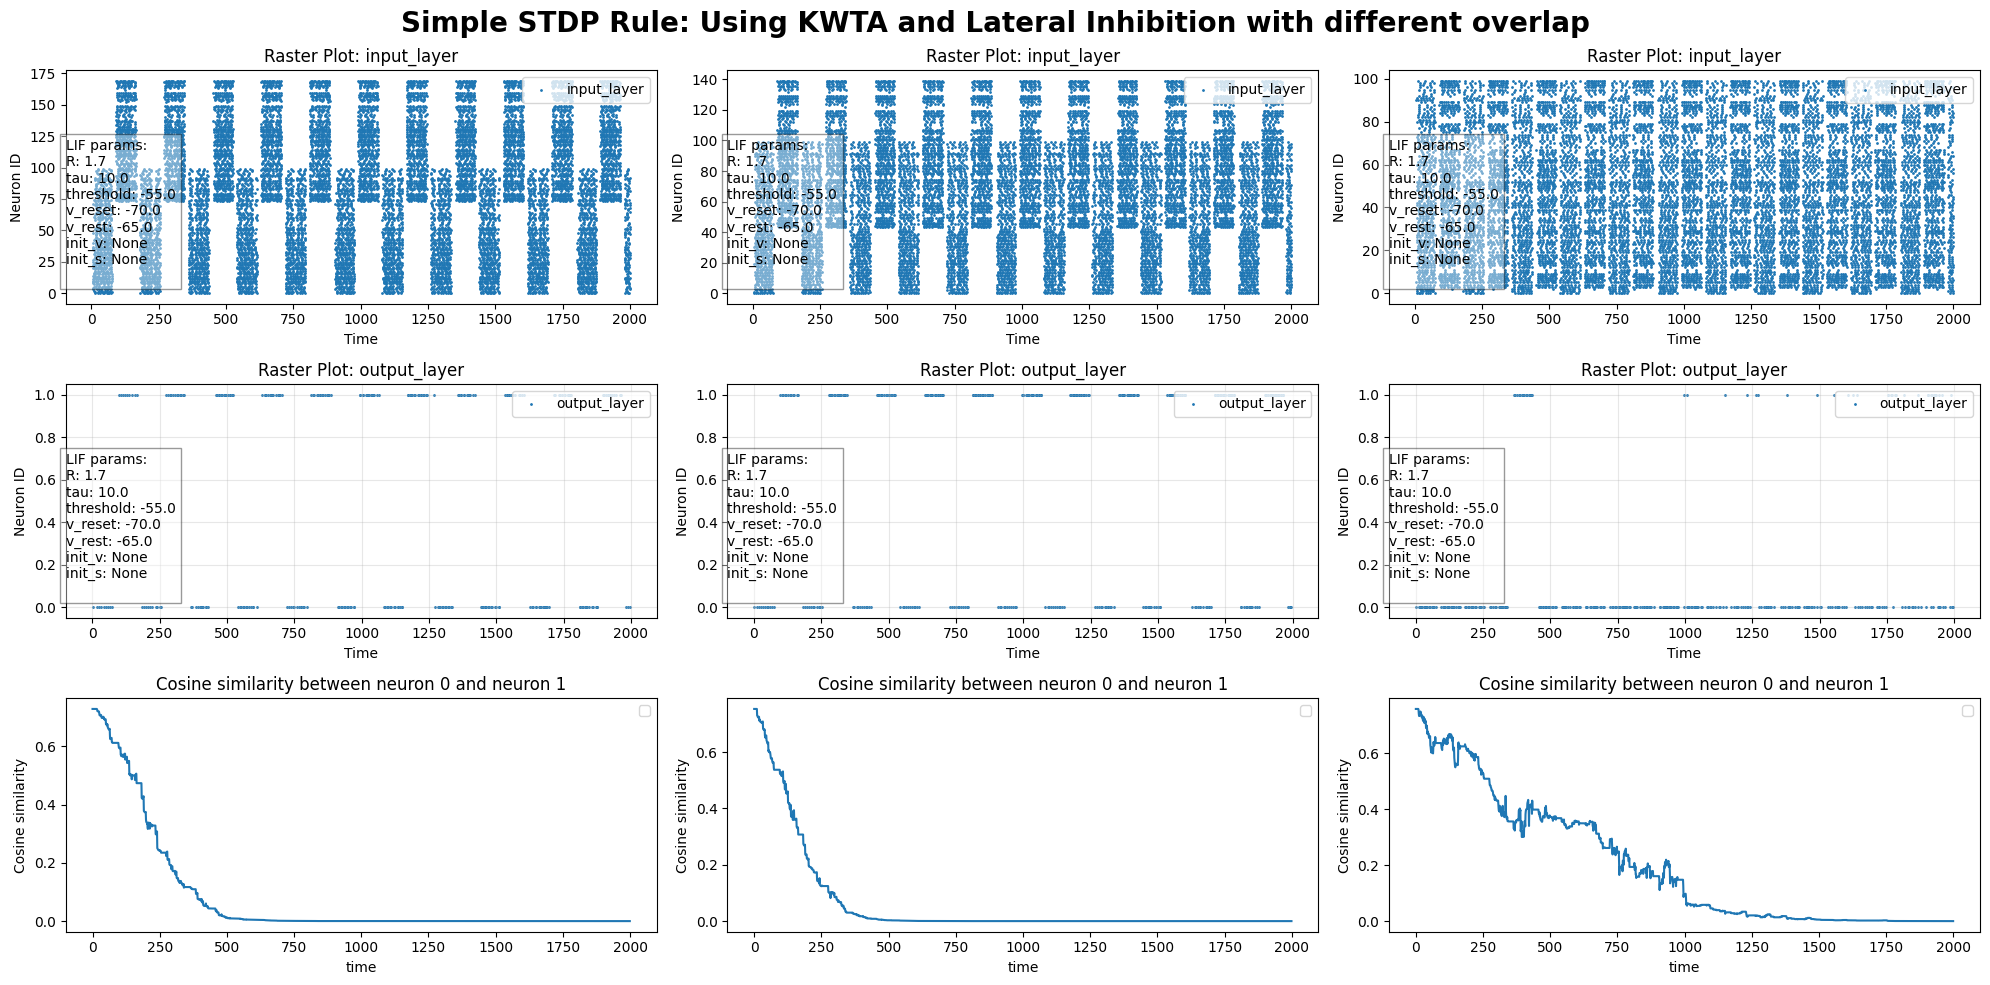

In [313]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(3, 3, 1)
sim1.net.NeuronGroups[0].add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
sim1.net.NeuronGroups[0].add_neuron_model_params_info(ax1,text_y=0.1, model_behavior_class=LIF)

ax2 = fig.add_subplot(3, 3, 2)
sim2.net.NeuronGroups[0].add_raster_plot(ax2, event_recorder_class=EventRecorder ,s=1)
sim2.net.NeuronGroups[0].add_neuron_model_params_info(ax2,text_y=0.1, model_behavior_class=LIF)

ax3 = fig.add_subplot(3, 3, 3)
sim3.net.NeuronGroups[0].add_raster_plot(ax3, event_recorder_class=EventRecorder ,s=1)
sim3.net.NeuronGroups[0].add_neuron_model_params_info(ax3,text_y=0.1, model_behavior_class=LIF)


ax4 = fig.add_subplot(3, 3, 4)
ax4.grid(True, alpha=0.3)
sim1.net.NeuronGroups[1].add_raster_plot(ax4, event_recorder_class=EventRecorder ,s=1)
sim1.net.NeuronGroups[1].add_neuron_model_params_info(ax4,text_y=0.1, model_behavior_class=LIF)

ax5 = fig.add_subplot(3, 3, 5)
ax5.grid(True, alpha=0.3)
sim2.net.NeuronGroups[1].add_raster_plot(ax5, event_recorder_class=EventRecorder ,s=1)
sim2.net.NeuronGroups[1].add_neuron_model_params_info(ax5,text_y=0.1, model_behavior_class=LIF)

ax6 = fig.add_subplot(3, 3, 6)
ax6.grid(True, alpha=0.3)
sim3.net.NeuronGroups[1].add_raster_plot(ax6, event_recorder_class=EventRecorder ,s=1)
sim3.net.NeuronGroups[1].add_neuron_model_params_info(ax6,text_y=0.1, model_behavior_class=LIF)


ax7 = fig.add_subplot(3, 3, 7)
sim1.net.SynapseGroups[0].add_cosine_similarity_plot(ax7,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax8 = fig.add_subplot(3, 3, 8)
sim2.net.SynapseGroups[0].add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

ax9 = fig.add_subplot(3, 3, 9)
sim3.net.SynapseGroups[0].add_cosine_similarity_plot(ax9,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)


fig.suptitle("Simple STDP Rule: Using KWTA and Lateral Inhibition with different overlap", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part1-simple-stdp-kwta-lateral-inhibition-different-overlap.pdf")
plt.show()